In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from pandas.plotting import autocorrelation_plot
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats
import pylab

from utils import *

In [2]:
df = pd.read_parquet("Sales_Data_v2.parquet")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8931111 entries, 0 to 8931110
Data columns (total 18 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Date               datetime64[ns]
 1   LocationId         int64         
 2   MainDistributorId  int64         
 3   DistributorId      int64         
 4   PackageId          int64         
 5   ProductId          int64         
 6   City               object        
 7   District           object        
 8   BrickId            int64         
 9   PaidQty            int64         
 10  FreeQty            int64         
 11  isPromoted         int64         
 12  Discount           float64       
 13  BeginDate          datetime64[ns]
 14  EndDate            datetime64[ns]
 15  Promo              object        
 16  DStep              float64       
 17  WeekStartDate      datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(9), object(3)
memory usage: 1.2+ GB


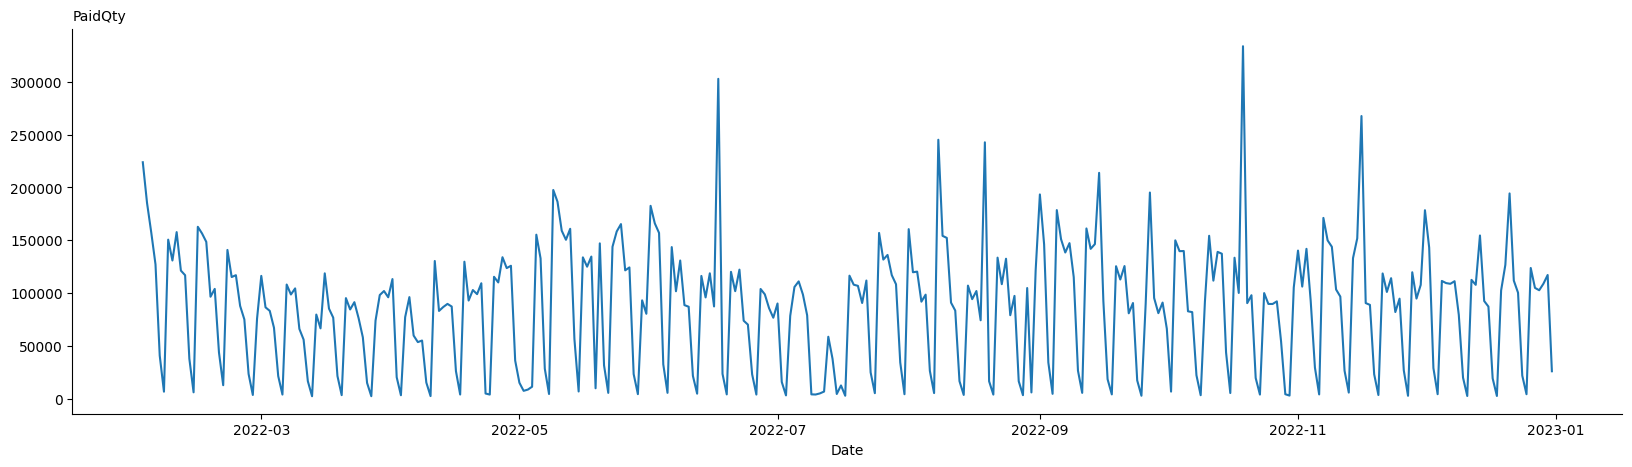

In [3]:
sales = df[df["Date"].dt.year == 2022]
sales = sales.groupby([sales['Date'].dt.date])['PaidQty'].sum()
sales.plot(figsize=(20,5), title="PaidQty")
plt.show()

In [4]:
df2 = df[["Date", "PaidQty", "FreeQty", "isPromoted", "Discount", "DStep"]].set_index("Date")
# Discount: Kullanılan oran, DStep: Geçerli olan teklifin oranı

In [6]:
df2.head()

,PaidQty,FreeQty,isPromoted,Discount,DStep
Date,,,,,
2023-01-02,10,0,0,0.0,0.0
2022-06-29,15,0,0,0.0,0.0
2023-01-04,3,0,0,0.0,0.0
2022-06-29,15,0,0,0.0,0.0
2023-01-04,20,0,0,0.0,0.0


In [7]:
fit = smf.ols('PaidQty ~ FreeQty', df2).fit()

In [8]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PaidQty   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                 4.558e+06
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:13:41   Log-Likelihood:            -3.2987e+07
No. Observations:             8931111   AIC:                         6.597e+07
Df Residuals:                 8931109   BIC:                         6.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1531      0.003   1570.571      0.000       5.147       5.160
FreeQty        1.6839      0.001   2134.847      0.000       1.682       1.685
==============================================================================
Omnibus:                 25864001.967   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   18404874264028.922
Skew:                          38.759   Prob(JB):                         0.00
Kurtosis:                    7035.228   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

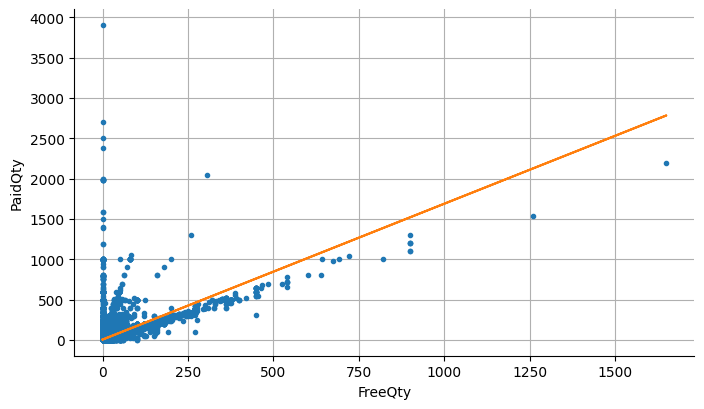

In [9]:
fig, ax = plt.subplots()
ax.plot(df2.FreeQty, df2.PaidQty, '.')
ax.plot(df2.FreeQty, fit.predict())
ax.set(ylabel="PaidQty", xlabel="FreeQty")
ax.grid()

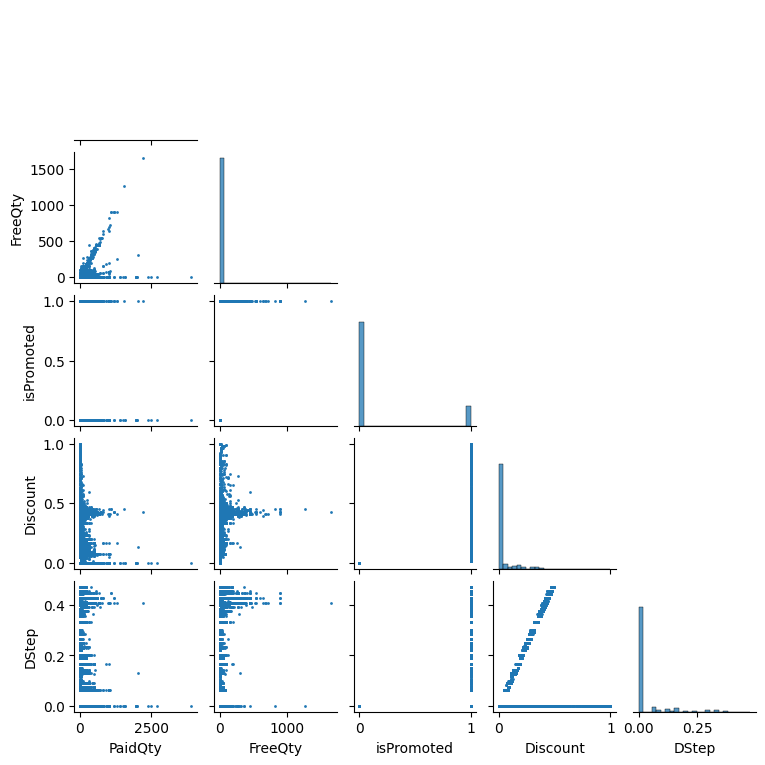

In [10]:
sns.pairplot(df2, plot_kws=dict(linewidth=0, s=4), corner=True, height=1.55);

In [11]:
fit = smf.ols('PaidQty ~ FreeQty + isPromoted + Discount + DStep', df2).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PaidQty   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                 1.602e+06
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:18:12   Log-Likelihood:            -3.2414e+07
No. Observations:             8931111   AIC:                         6.483e+07
Df Residuals:                 8931106   BIC:                         6.483e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3427      0.003   1301.589      0.000       4.336       4.349
FreeQty        1.7864      0.001   2176.747      0.000       1.785       1.788
isPromoted    16.5962      0.015   1104.645      0.000      16.567      16.626
Discount     -40.3863      0.249   -162.088      0.000     -40.875     -39.898
DStep        -30.5219      0.246   -124.045      0.000     -31.004     -30.040
==============================================================================
Omnibus:                 27293735.413   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   30493194616403.203
Skew:                          45.031   Prob(JB):                         0.00
Kurtosis:                    9054.756   Cond. No.                         472.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Single Product & Daily Aggregation

In [5]:
prod_29 = df[df["ProductId"]==29]
prod_29 = prod_29.groupby([prod_29['Date'].dt.date])[["PaidQty", "FreeQty"]].sum()
prod_29

,PaidQty,FreeQty
Date,,
2022-02-01,10077,0
2022-02-02,7830,0
2022-02-03,7103,0
2022-02-04,7093,25
2022-02-05,2380,0
...,...,...
2023-09-26,7217,145
2023-09-27,5163,85
2023-09-28,4640,84


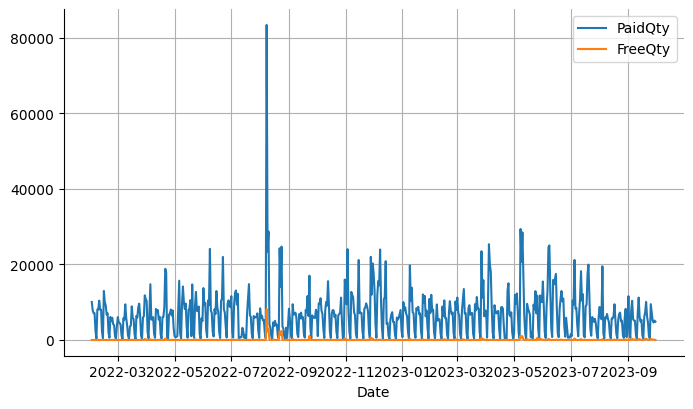

In [30]:
fig, ax = plt.subplots()
prod_29.plot(ax=ax)
ax.grid()

In [31]:
fit = smf.ols('PaidQty ~ FreeQty', prod_29).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PaidQty   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     440.4
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           6.95e-74
Time:                        21:23:32   Log-Likelihood:                -5993.2
No. Observations:                 607   AIC:                         1.199e+04
Df Residuals:                     605   BIC:                         1.200e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6197.9828    193.416     32.045      0.000    5818.134    6577.832
FreeQty        9.9107      0.472     20.986      0.000       8.983      10.838
==============================================================================
Omnibus:                       89.865   Durbin-Watson:                   1.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.722
Skew:                           0.963   Prob(JB):                     4.57e-31
Kurtosis:                       4.347   Cond. No.                         415.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

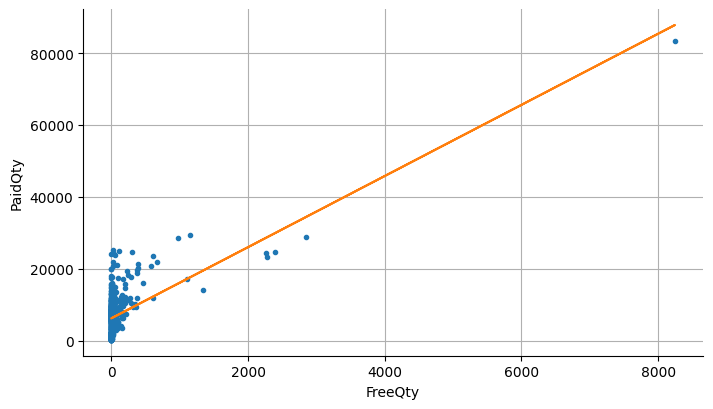

In [33]:
fig, ax = plt.subplots()
ax.plot(prod_29.FreeQty, prod_29.PaidQty, '.')
ax.plot(prod_29.FreeQty, fit.predict())
ax.set(ylabel="PaidQty", xlabel="FreeQty")
ax.grid()

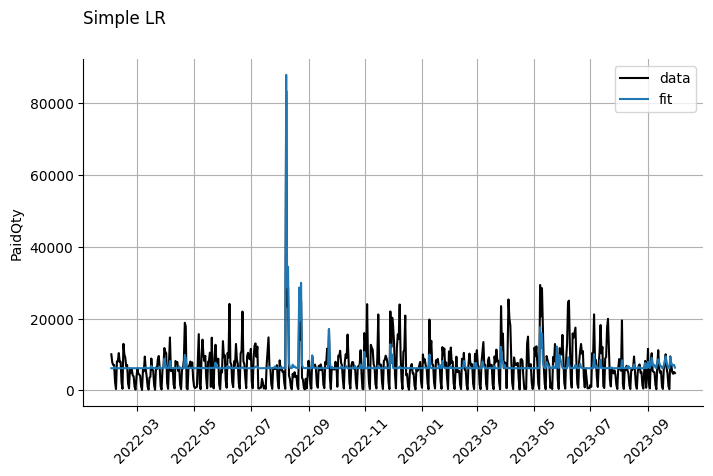

In [35]:
fig, ax = plt.subplots()
ax.plot(prod_29.PaidQty, label='data', color='k')
ax.plot(prod_29.index, fit.predict(), label='fit')
ax.set(ylabel='PaidQty')
suptitle('Simple LR')
plt.xticks(rotation=45)
ax.legend()
ax.grid()

c:\Users\ayigi\Desktop\Promo\PharmaProject\utils.py:124: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),


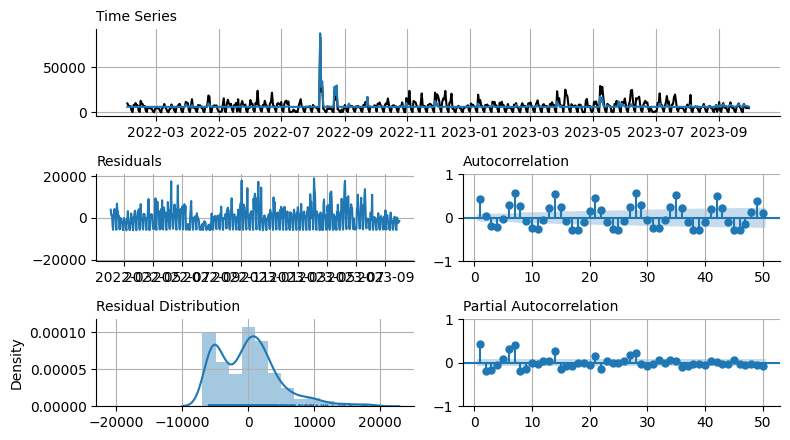

In [40]:
ypred = pd.Series(fit.predict(), index=prod_29.index)
plot_tsresiduals(prod_29.PaidQty, ypred, acf_lags=np.r_[1:51]);

In [54]:
# Model: Weekly plus linear trend.

d = prod_29.assign(
    weekday = prod_29.index.to_series().apply(lambda x: x.weekday()),
    index = np.arange(len(prod_29)))
d.head(7)

,PaidQty,FreeQty,weekday,index
Date,,,,
2022-02-01,10077,0,1,0
2022-02-02,7830,0,2,1
2022-02-03,7103,0,3,2
2022-02-04,7093,25,4,3
2022-02-05,2380,0,5,4
2022-02-06,396,0,6,5
2022-02-07,8087,0,0,6


In [56]:
fit = smf.ols('PaidQty ~ index + weekday + FreeQty', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PaidQty   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     313.9
Date:                Sun, 03 Dec 2023   Prob (F-statistic):          1.03e-122
Time:                        22:06:06   Log-Likelihood:                -5873.7
No. Observations:                 607   AIC:                         1.176e+04
Df Residuals:                     603   BIC:                         1.177e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9877.1576    396.956     24.882      0.000    9097.574    1.07e+04
index          1.4229      0.896      1.587      0.113      -0.338       3.184
weekday    -1350.0042     79.478    -16.986      0.000   -1506.092   -1193.917
FreeQty        8.9873      0.392     22.907      0.000       8.217       9.758
==============================================================================
Omnibus:                      195.296   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              621.641
Skew:                           1.531   Prob(JB):                    1.03e-135
Kurtosis:                       6.899   Cond. No.                     1.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

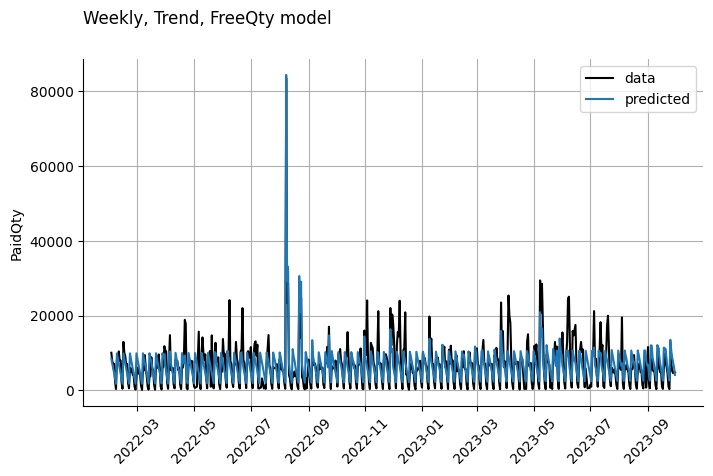

In [58]:
ypred = pd.Series(fit.predict(), index=d.index)
fig, ax = plt.subplots()
ax.plot(d.PaidQty, color='k', label='data')
ax.plot(ypred, label='predicted')
ax.legend()
ax.set(ylabel='PaidQty')
suptitle('Weekly, Trend, FreeQty model')
plt.xticks(rotation=45)
ax.grid()

c:\Users\ayigi\Desktop\Promo\PharmaProject\utils.py:124: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),


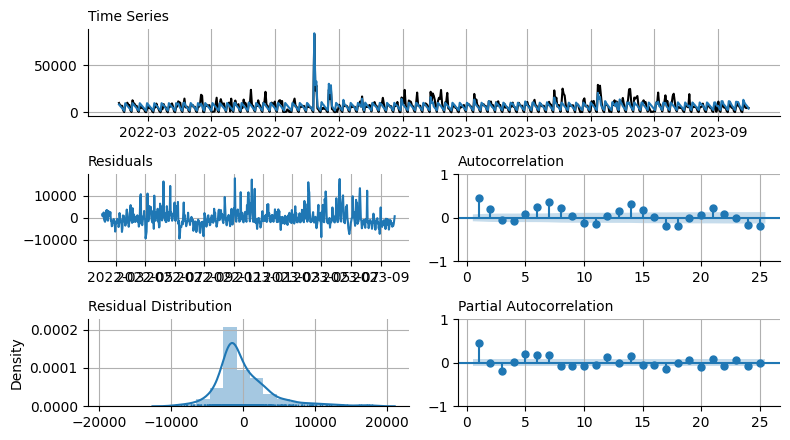

In [59]:
plot_tsresiduals(d.PaidQty, ypred);

In [62]:
dict(rsquared = fit.rsquared,
     rsquared_adj = fit.rsquared_adj,
     aic = fit.aic,
     bic = fit.bic)

{'rsquared': 0.6096411717942547,
 'rsquared_adj': 0.607699088071838,
 'aic': 11755.4551154629,
 'bic': 11773.089230627138}

# ARIMA Models

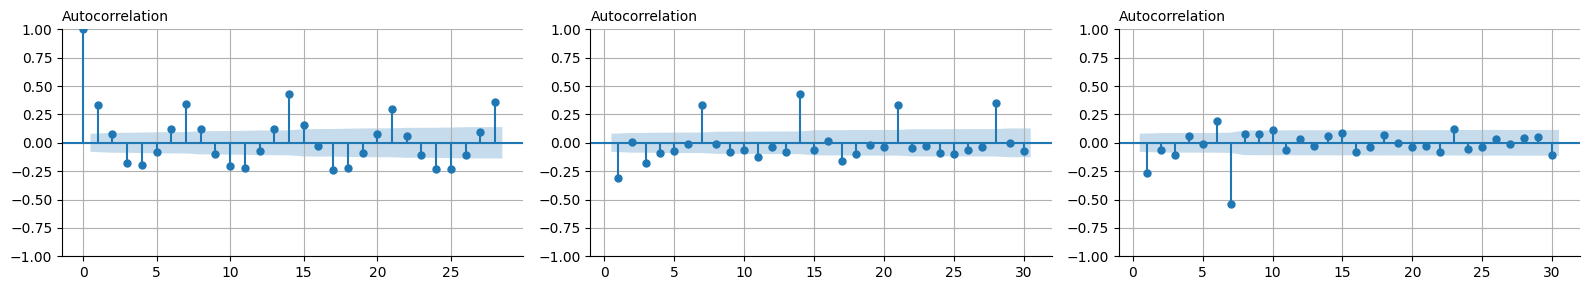

In [18]:
# ACF vs Differenced Series ACF vs Two Times Differenced log Series

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(16,3))
d = prod_29
sm.graphics.tsa.plot_acf(d.PaidQty, ax=a1)
sm.graphics.tsa.plot_acf(d.PaidQty.diff().dropna(), lags=np.r_[1:31], ax=a2)
sm.graphics.tsa.plot_acf(np.log(d.PaidQty).diff().diff(7).dropna(), lags=np.r_[1:31], ax=a3)
[ax.grid() for ax in (a1,a2,a3)]
plt.tight_layout()

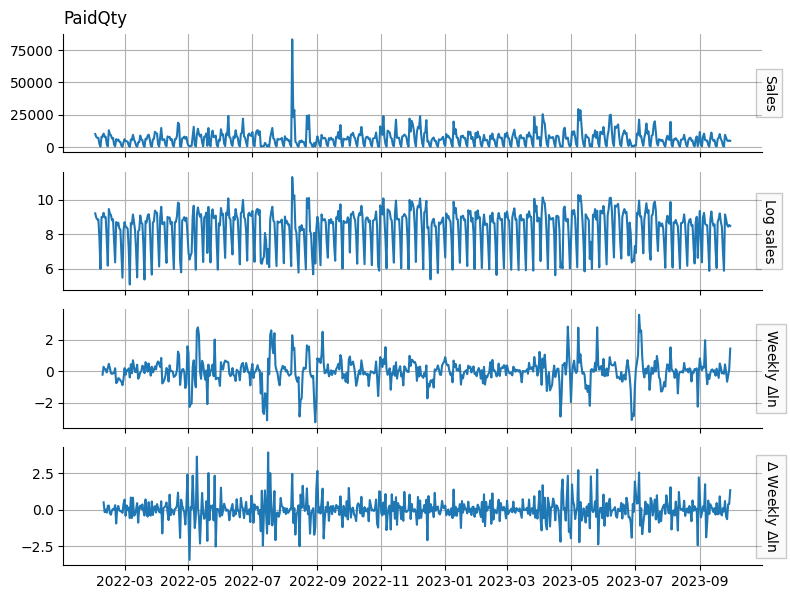

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True)
axs[0].plot(d.PaidQty)
axs[1].plot(np.log(d.PaidQty))
axs[2].plot(np.log(d.PaidQty).diff(7))
axs[3].plot(np.log(d.PaidQty).diff(7).diff())
titles = 'Sales', 'Log sales',  'Weekly $\Delta\ln$', '$\Delta$ Weekly $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('PaidQty')
fig.subplots_adjust(top=.95)

## Unit Root Test

In [12]:
# Unit Root Test

sm.tsa.stattools.kpss(d.PaidQty, nlags='auto')

C:\Users\ayigi\AppData\Local\Temp\ipykernel_4764\1421723430.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(d.PaidQty, nlags='auto')


(0.18525428434912058,
 0.1,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [15]:
sm.tsa.stattools.kpss(np.log(d.PaidQty).diff(7).dropna(), nlags='auto')

C:\Users\ayigi\AppData\Local\Temp\ipykernel_4764\1856896965.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  sm.tsa.stattools.kpss(np.log(d.PaidQty).diff(7).dropna(), nlags='auto')


(0.009557777823838718,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})